# **Tanzanian Water Wells: Predictive Maintenance for Clean Water Access**

## Executive Summary

This project addresses a critical challenge in Tanzania: **predicting the operational status of water wells** to optimize maintenance efforts and ensure reliable access to clean water for communities across the country. By leveraging machine learning classification techniques, we aim to help stakeholders prioritize resources and prevent water access disruptions.

**Key Findings:**
- Built and evaluated multiple classification models to predict well functionality
- Identified critical features that determine well failure
- Provided actionable recommendations for maintenance prioritization

# 1. Business Understanding

## 1.1 The Stakeholder

Our primary stakeholders are:
- **Tanzanian Ministry of Water**: Government agency responsible for water infrastructure
- **International NGOs**: Organizations funding and maintaining water wells
- **Local Communities**: End users dependent on functional water sources

## 1.2 The Business Problem

Tanzania faces a significant challenge with water well functionality. Many wells fall into disrepair, leaving communities without access to clean water. The problem:

- **Reactive maintenance is inefficient**: Wells are only serviced after complete failure
- **Resource constraints**: Limited funding and personnel require strategic allocation
- **Impact on communities**: Non-functional wells force communities to use unsafe water sources

## 1.3 The Business Goal

Develop a predictive model that can classify water wells into three categories:
1. **Functional**: Well is operational and needs no immediate attention
2. **Functional needs repair**: Well works but requires maintenance soon
3. **Non-functional**: Well is broken and needs immediate intervention

## 1.4 Why This Matters

Accurate predictions enable stakeholders to:
- **Prevent failures**: Address wells needing repair before they break completely
- **Optimize resources**: Focus maintenance crews on high-risk areas
- **Improve public health**: Ensure consistent access to clean water
- **Save costs**: Preventive maintenance is cheaper than emergency repairs
- **Data-driven decisions**: Move from reactive to proactive water management

# 2. Data Understanding

## 2.1 Dataset Overview

We have three data files:
- **Training set values**: Features for 59,400 wells used to train models
- **Training set labels**: The operational status (target variable) for training wells
- **Test set values**: Features for 14,850 wells where we need to predict status

### Iporting neccessary libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

### Loading the datasets and submission format

In [3]:
# datasets
train_labels = pd.read_csv("0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
test_values = pd.read_csv("702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")
train_values = pd.read_csv("4910797b-ee55-40a7-8668-10efd5c1b960.csv")
submission_format = pd.read_csv("SubmissionFormat.csv")

# data overview
print(f"Training set: {train_values.shape[0]:,} wells, {train_values.shape[1]} features")
print(f"Test set: {test_values.shape[0]:,} wells, {test_values.shape[1]} features")
print(f"Labels: {train_labels.shape[0]:,} records")

Training set: 59,400 wells, 40 features
Test set: 14,850 wells, 40 features
Labels: 59,400 records


## 2.2 Merging Training Data

The features and labels are in separate files. They need merging using the `id` column to create a complete training dataset.

In [4]:
# Merge training values with labels
train_df = train_values.merge(train_labels, on='id', how='inner')

train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [5]:
print(f"Complete training dataset: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")
print("      ")
train_df.info()

Complete training dataset: 59,400 rows, 41 columns
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 

## 2.3 Target Variable Distribution

Examining target variable: **status_group**. Understanding its distribution is critical for model evaluation.

In [6]:
# target variable distribution

print("Target Variable Distribution:")
target_counts = train_df['status_group'].value_counts()
print(target_counts)

Target Variable Distribution:
status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64


In [7]:
# target variable distribution percentages

target_pcts = train_df['status_group'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(" "*10)
for status in target_counts.index:
    count = target_counts[status]
    pct = target_pcts[status]
    print(f"{status}: {pct:.2f}%")

Target Variable Distribution:
          
functional: 54.31%
non functional: 38.42%
functional needs repair: 7.27%


The target variable has three outcomes with fucntional wells been dominant and those that are functional and need repairs been the least.

### Visualizing the distribution

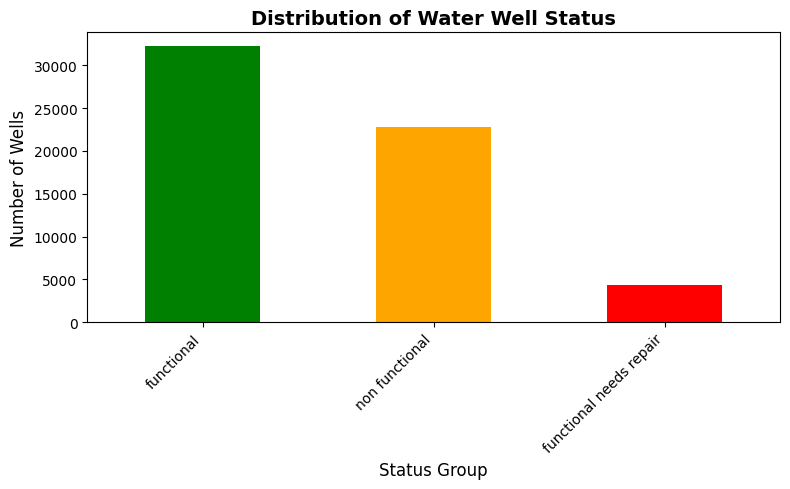

In [46]:
# Visualizing the distribution

plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Water Well Status', fontsize=14, fontweight='bold')
plt.xlabel('Status Group', fontsize=12)
plt.ylabel('Number of Wells', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observations on Target Variable:

- **Class imbalance may exist**: If one class dominates, the model might be biased toward predicting that class - functional is more dominant
- **Multi-class problem**: We're predicting three outcomes, not just binary (working vs. broken)
- **Business priority**: Identifying "functional needs repair" is valuable for preventive maintenance

## 2.4 Feature Overview

Examining the types of features available for prediction.

In [9]:
# basic information about the training data
print("Dataset Information:")
print(" "*4)
train_df.info()

Dataset Information:
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400

The dataset contains both numeric and categorical features

In [10]:
# Separating numeric and categorical features
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove id and target from feature lists
numeric_features = [f for f in numeric_features if f != 'id']
categorical_features = [f for f in categorical_features if f != 'status_group']


In [11]:
print(f"Total features: {len(numeric_features) + len(categorical_features)}")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")

Total features: 39
  - Numeric features: 9
  - Categorical features: 30


## 2.5 Missing Values Analysis

In [12]:
# Calculating the missing values
missing_counts = train_df.isnull().sum()
missing_counts

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Missing Data Observations:

- **High missing percentages** (>40%): should drop these features as imputation may introduce too much bias
- **Moderate missing** (10-40%): Can impute with appropriate strategies
- **Low missing** (<10%): Can impute or drop rows depending on feature importance

## 2.6 Summary Statistics

In [13]:
# Summary statistics for numeric features
train_df[numeric_features].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [49]:
# Summary statistics for categorical_features 

train_df[categorical_features].head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,Mara,Serengeti,Natta,NaN,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,Manyara,Simanjiro,Ngorika,True,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,Nanyumbu,Nanyumbu,True,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,Kagera,Karagwe,Nyakasimbi,True,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## 2.7 Key Feature Insights

critical features that likely influence well functionality

In [14]:
# Analyzing quantity (water availability)
print("Water Quantity Distribution by Status:")
print(" ")

quantity_status = pd.crosstab(train_df['quantity'], train_df['status_group'], normalize='index') * 100
quantity_status.round(2)

Water Quantity Distribution by Status:
 


status_group,functional,functional needs repair,non functional
quantity,,,
dry,2.51,0.59,96.89
enough,65.23,7.23,27.54
insufficient,52.32,9.58,38.09
seasonal,57.41,10.27,32.32
unknown,27.00,1.77,71.23


Wells with little or no water are much more likely to fail, while wells with enough water usually work. This makes water quantity a useful predictor of well functionality.

The feature `water quantity` shows strong class separation, with dry and unknown categories heavily associated with non-functional wells. This suggests high feature importance.

### Water Quantity Distribution

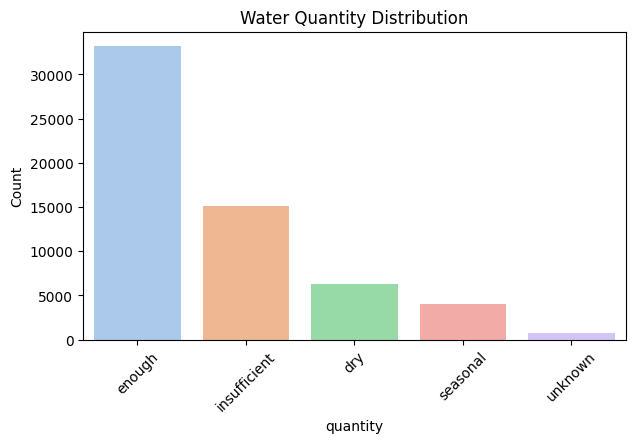

In [15]:
# Quantity distribution

import seaborn as sns

plt.figure(figsize=(7, 4))
quantity_status = pd.crosstab(train_df['quantity'], train_df['status_group'], normalize='index') * 100
quantity_counts = train_df['quantity'].value_counts()

sns.barplot(x=quantity_counts.index, y=quantity_counts.values,hue=quantity_counts.index, palette="pastel")

plt.title('Water Quantity Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.show()


Water Quality Distribution (Top 10)

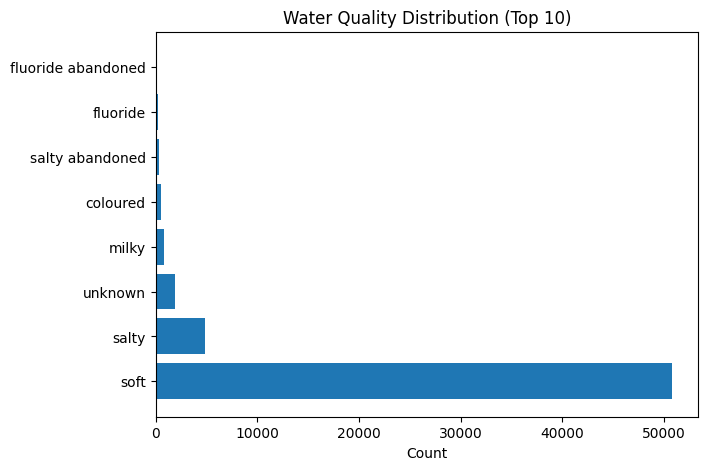

In [16]:
plt.figure(figsize=(7, 5))

quality_counts = train_df['water_quality'].value_counts().head(10)
plt.barh(quality_counts.index, quality_counts.values)

plt.title('Water Quality Distribution (Top 10)')
plt.xlabel('Count')

plt.show()


### Key Insights:

1. Multi-class classification: need models that can handle three outcome categories
2. Mixed feature types: Both numeric and categorical features require different preprocessing
3. Missing data present**: need to handle missing values
4. High cardinality: Some categorical features (funder, installer) have many unique values
5. Geographic features: Longitude, latitude, and region could be important predictors
6. Time component: Date recorded and construction year may reveal aging patterns

# 3. Data Preparation

Cleaning and transforming the data to prepare it for ML models:

1. **Handle missing values** appropriately
2. **Select relevant features** to avoid overfitting
3. **Encode categorical variables** for model compatibility
4. **Split data** into training and validation sets
5. **Scale features** for logistic regression
6. **Avoid data leakage** by fitting preprocessors only on training data

## 3.1 Feature Selection Strategy

We select features based on:
- **Relevance** to predicting well functionality
- **Missing data** percentage
- **Cardinality** (avoiding features with too many unique values)
- **Redundancy** (avoiding duplicate information)

In [17]:
# Creating a copy for preprocessing - to avoid modifying original data
df_clean = train_df.copy()
test_clean = test_values.copy()

In [18]:
# Drop features with too many missing values or low relevance
# scheme_name has ~48% missing, wpt_name is too unique to be useful
drop_features = [
    'id',                    # Identifier, not predictive
    'wpt_name',              # Too many unique values (nearly all unique)
    'scheme_name',           # 48% missing
    'subvillage',            # Too granular, region/ward should suffice
    'recorded_by',           # Single value (GeoData Consultants)
    'num_private',           # Mostly zeros, low variance
    'date_recorded',         # Will feature engineer from this
]

# droping redundant feature groups (keep only one from similar features)
# extraction_type, extraction_type_group, extraction_type_class are similar
# Keep extraction_type_class (most general)
drop_features.extend([
    'extraction_type',
    'extraction_type_group',
    'payment',               # Keep payment_type
    'management_group',      # Keep management
    'quality_group',         # Keep water_quality
    'quantity_group',        # Keep quantity
    'source_type',           # Keep source
    'source_class',          # Keep source
    'waterpoint_type_group', # Keep waterpoint_type
])

print(f"Dropped {len(drop_features)} features")
print(f"Features remaining: {df_clean.shape[1] - len(drop_features) - 1}")  # -1 for target

Dropped 16 features
Features remaining: 24


## 3.2 Feature Engineering: Well Age

**Hypothesis**: Older wells are more likely to be non-functional.  
we create a "well_age" feature from the construction year and date recorded.

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

converting date recorded to datetime & extracting the year

In [20]:
# Convert date_recorded to datetime and extract year
df_clean['date_recorded'] = pd.to_datetime(df_clean['date_recorded'])
df_clean['year_recorded'] = df_clean['date_recorded'].dt.year

In [51]:
df_clean.head(2)

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,permit,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,status_group,well_age
0,6000.0,Roman,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,...,False,gravity,vwc,annually,soft,enough,spring,communal standpipe,functional,12
1,0.0,Grumeti,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,...,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,3


In [21]:
test_clean['date_recorded'] = pd.to_datetime(test_clean['date_recorded'])
test_clean['year_recorded'] = test_clean['date_recorded'].dt.year   # extract year

In [52]:
test_clean.head(2)

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,...,scheme_management,permit,extraction_type_class,management,payment_type,water_quality,quantity,source,waterpoint_type,well_age
0,0.0,Dmdd,1996,DMDD,35.290799,-4.059696,Internal,Manyara,21,3,...,Parastatal,True,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other,1
1,0.0,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Pangani,Arusha,2,2,...,VWC,True,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,13


In [22]:
# Calculate well age (handle construction_year = 0 as missing)
df_clean['well_age'] = df_clean['year_recorded'] - df_clean['construction_year']
df_clean.loc[df_clean['construction_year'] == 0, 'well_age'] = df_clean['well_age'].median()

test_clean['well_age'] = test_clean['year_recorded'] - test_clean['construction_year']
test_clean.loc[test_clean['construction_year'] == 0, 'well_age'] = df_clean['well_age'].median()

# Drop original date features
drop_features.extend(['construction_year', 'year_recorded'])

df_clean['well_age'].describe()
# stats for well_age

count    59400.000000
mean        19.066717
std         11.286499
min         -7.000000
25%          8.000000
50%         26.000000
75%         26.000000
max         53.000000
Name: well_age, dtype: float64

## 3.3 Handle Missing Values

Our strategy:
- **Categorical features**: Fill missing with 'unknown'
- **Numeric features**: Fill with median 

In [23]:
# Handle missing values in categorical features
categorical_cols = df_clean.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'status_group']

for col in categorical_cols:
    if col not in drop_features:
        df_clean[col].fillna('unknown', inplace=True)
        test_clean[col].fillna('unknown', inplace=True)

# Handle missing values in numeric features
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in drop_features and col != 'id']

for col in numeric_cols:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)
    test_clean[col].fillna(median_val, inplace=True)

print(f"Remaining missing values in training: {df_clean.isnull().sum().sum()}")
print(f"Remaining missing values in test: {test_clean.isnull().sum().sum()}")

Remaining missing values in training: 29183
Remaining missing values in test: 7341


## 3.4 Encode Categorical Variables

Label Encoding for categorical features.

In [24]:
# Drop features we decided to exclude
df_clean.drop(columns=drop_features, errors='ignore', inplace=True)
test_clean.drop(columns=drop_features, errors='ignore', inplace=True)

# Separate features and target
X = df_clean.drop(columns=['status_group'])
y = df_clean['status_group']
X_test_final = test_clean.copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Test set shape: {X_test_final.shape}")

Feature matrix shape: (59400, 24)
Target variable shape: (59400,)
Test set shape: (14850, 24)


In [25]:
# categorical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features to encode: {len(cat_cols)}")

Categorical features to encode: 16


In [26]:
# Label encode categorical features (FAST, same functionality)
label_encoders = {}

for col in cat_cols:
    label = LabelEncoder()

    # Fit on training data
    X[col] = label.fit_transform(X[col].astype(str))

    # Fast transform for test data (unseen → -1)
    mapping = dict(zip(label.classes_, range(len(label.classes_))))
    X_test_final[col] = (X_test_final[col].astype(str).map(mapping).fillna(-1).astype(int))

    label_encoders[col] = label


In [27]:
# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"Target classes: {target_encoder.classes_}")

Target classes: ['functional' 'functional needs repair' 'non functional']


checking if nulls have been delt with

In [28]:
df_clean.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
status_group             0
well_age                 0
dtype: int64

In [29]:
test_clean.isnull().sum()

amount_tsh               0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
extraction_type_class    0
management               0
payment_type             0
water_quality            0
quantity                 0
source                   0
waterpoint_type          0
well_age                 0
dtype: int64

## 3.5 Train-Test Split

- **Training set (80%)**: Used to train the model
- **Validation set (20%)**: Used to evaluate model performance
- **random_state=42**

This helps us assess how well our model generalizes to unseen data.

In [30]:
# Split the data

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)  

# stratify=y_encoded- Maintain class distribution
# The data is split into training and validation sets to allow model learning and hyperparameter tuning while preserving class balance through stratification.

Data Split Summary

In [31]:
print(f"Training set:   {X_train.shape[0]:6,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:6,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Features:       {X_train.shape[1]:6} features")

Training set:   47,520 samples (80.0%)
Validation set: 11,880 samples (20.0%)
Features:           24 features


In [32]:
X_train.shape

(47520, 24)

In [33]:
X_val.shape

(11880, 24)

In [34]:
# Class distribution maintained
train_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
val_dist = pd.Series(y_val).value_counts(normalize=True).sort_index()
for i, class_name in enumerate(target_encoder.classes_):
    print(f"{class_name:25s}: Train {train_dist[i]*100:5.2f}%  |  Val {val_dist[i]*100:5.2f}%")

functional               : Train 54.31%  |  Val 54.31%
functional needs repair  : Train  7.27%  |  Val  7.26%
non functional           : Train 38.42%  |  Val 38.43%


## 3.6 Feature Scaling

**Logistic Regression** is sensitive to feature scales. Features with larger ranges can dominate the model.  
We'll use **StandardScaler** to normalize features (mean=0, std=1).

**Critical**: Fit scaler on training data only, then transform both train and validation sets.

In [35]:
# Initializing scaler
scaler = StandardScaler()

# Fitting on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print("Features scaled using StandardScaler")
print(f"Scaled training set mean: {X_train_scaled.mean():.4f}")
print(f"Scaled training set std:  {X_train_scaled.std():.4f}")

# Keeping unscaled versions for Decision Tree 
X_train_unscaled = X_train.copy()
X_val_unscaled = X_val.copy()

# Data preparation complete

Features scaled using StandardScaler
Scaled training set mean: -0.0000
Scaled training set std:  1.0000


the mean for the scaled dataset is 0 and std is 1. This confirms that scaling has been done correctly.

# 4. Modeling

Build and comparing two classification models:

1. **Logistic Regression**: A linear model that works well as a baseline
2. **Decision Tree**: A non-linear model that can capture complex patterns

For each model, we will:
- Start with a baseline (default parameters)
- Tune parameters to improve performance
- Evaluate on validation data

## 4.1 Baseline Model: Logistic Regression

**Why Logistic Regression?**
- Simple and interpretable
- Fast to train
- Works well when relationships are approximately linear
- Good baseline for comparison

- Calculates probability of each class based on weighted feature combinations.

## Baseline multinomial logistic regression

In [36]:
# Training Baseline Logistic Regression

lr_baseline = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')

lr_baseline.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_baseline.predict(X_train_scaled)
y_val_pred_lr = lr_baseline.predict(X_val_scaled)

In [37]:
# Calculating metrics
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)

In [38]:
print(f"Training Accuracy:   {train_acc_lr:.4f}")

Training Accuracy:   0.6355


In [39]:
print(f"Validation Accuracy: {val_acc_lr:.4f}")

Validation Accuracy: 0.6321


## 4.2 Tuned Model: Logistic Regression with Regularization

**Regularization** helps prevent overfitting by penalizing large coefficients. 

In [53]:
# Trying different regularization strengths
# Tuning Logistic Regression (testing C values)


c_values = [0.01, 0.1, 1.0, 10.0]
results = []

for c in c_values:
    lr = LogisticRegression(C=c, max_iter=1000, random_state=42,multi_class='multinomial')
    lr.fit(X_train_scaled, y_train)
    
    val_acc = accuracy_score(y_val, lr.predict(X_val_scaled))
    results.append({'C': c, 'Validation_Accuracy': val_acc})
    print(f"C = {c:6.2f}  →  Validation Accuracy: {val_acc:.4f}")

# Find best C
results_df = pd.DataFrame(results)
best_c = results_df.loc[results_df['Validation_Accuracy'].idxmax(), 'C']
best_acc = results_df['Validation_Accuracy'].max()

print(f"Best C value: {best_c} with validation accuracy: {best_acc:.4f}")

C =   0.01  →  Validation Accuracy: 0.6317
C =   0.10  →  Validation Accuracy: 0.6322
C =   1.00  →  Validation Accuracy: 0.6321
C =  10.00  →  Validation Accuracy: 0.6321
Best C value: 0.1 with validation accuracy: 0.6322


## 4.3 Baseline Model: Decision Tree

**Why Decision Tree?**
- Can capture non-linear patterns
- Doesn't require feature scaling
- Easy to interpret (can visualize decision rules)
- Handles mixed data types naturally

It creates a tree of decision rules based on feature values.

In [41]:
# Training Baseline Decision Tree

dt_baseline = DecisionTreeClassifier(random_state=42)

dt_baseline.fit(X_train_unscaled, y_train)

# Make predictions
y_train_pred_dt = dt_baseline.predict(X_train_unscaled)
y_val_pred_dt = dt_baseline.predict(X_val_unscaled)

# Model trained successfully

In [42]:
# Calculating metrics
train_acc_dt = accuracy_score(y_train, y_train_pred_dt)
val_acc_dt = accuracy_score(y_val, y_val_pred_dt)

print(f"Training Accuracy:   {train_acc_dt:.4f} ({train_acc_dt*100:.2f}%)")
print(f"Validation Accuracy: {val_acc_dt:.4f} ({val_acc_dt*100:.2f}%)")
print(" ")

if train_acc_dt - val_acc_dt > 0.05:
    print("Warning: Large gap between training and validation accuracy suggests overfitting.")

Training Accuracy:   0.9979 (99.79%)
Validation Accuracy: 0.7561 (75.61%)
 


## 4.4 Tuned Model: Decision Tree with Depth Limit

**Problem with baseline**: Decision trees can overfit by growing too deep.  
**Solution**: Limit tree depth and require minimum samples per leaf.

Parameters to tune:
- **max_depth**: Maximum tree depth
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples required in a leaf node

In [43]:
# Trying different max_depth values

depth_values = [5, 10, 15, 20, 25]
dt_results = []

for depth in depth_values:
    dt = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_split=100,
        min_samples_leaf=50,
        random_state=42
    )
    dt.fit(X_train_unscaled, y_train)
    
    train_acc = accuracy_score(y_train, dt.predict(X_train_unscaled))
    val_acc = accuracy_score(y_val, dt.predict(X_val_unscaled))
    
    dt_results.append({
        'Max_Depth': depth, 
        'Train_Accuracy': train_acc,
        'Val_Accuracy': val_acc,
        'Overfit_Gap': train_acc - val_acc
    })
    print(f"Depth = {depth:2d}  →  Train: {train_acc:.4f}  |  Val: {val_acc:.4f}  |  Gap: {train_acc-val_acc:.4f}")

# Find best depth
dt_results_df = pd.DataFrame(dt_results)
best_depth = dt_results_df.loc[dt_results_df['Val_Accuracy'].idxmax(), 'Max_Depth']
best_dt_acc = dt_results_df['Val_Accuracy'].max()

print(f"Best max_depth: {best_depth} with validation accuracy: {best_dt_acc:.4f}")

Depth =  5  →  Train: 0.7128  |  Val: 0.7099  |  Gap: 0.0029
Depth = 10  →  Train: 0.7472  |  Val: 0.7386  |  Gap: 0.0086
Depth = 15  →  Train: 0.7677  |  Val: 0.7519  |  Gap: 0.0158
Depth = 20  →  Train: 0.7771  |  Val: 0.7582  |  Gap: 0.0190
Depth = 25  →  Train: 0.7778  |  Val: 0.7588  |  Gap: 0.0190
Best max_depth: 25 with validation accuracy: 0.7588


In [44]:
# Training final tuned decision tree
dt_tuned = DecisionTreeClassifier(max_depth=int(best_depth),min_samples_split=100,min_samples_leaf=50,random_state=42)

dt_tuned.fit(X_train_unscaled, y_train)
y_val_pred_dt_tuned = dt_tuned.predict(X_val_unscaled)

print(f"Tuned Decision Tree trained with max_depth = {best_depth}")

Tuned Decision Tree trained with max_depth = 25


### Modeling Summary:

We've trained four models:
1. ✓ Baseline Logistic Regression
2. ✓ Tuned Logistic Regression (regularization)
3. ✓ Baseline Decision Tree
4. ✓ Tuned Decision Tree (depth limit)

The next bit is comprehensively evaluating and comparing these models.


# 5. Model Evaluation

Evaluating classification models requires more than just accuracy. We need to understand:
- **How often is the model correct?** (Accuracy)
- **When it predicts a class, how often is it right?** (Precision)
- **Of all actual instances of a class, how many did it catch?** (Recall)
- **Balance between precision and recall?** (F1-score)
- **What types of errors is it making?** (Confusion Matrix)

## 5.1 Model Comparison: Overall Accuracy